# Final Project


Ariane Tsai

I wrote the code for organizing the tags and titles into dictionaries, as well as created the bar chart and pie chart visualizations. I also participated in discussions with my group regarding the big picture and what data would be needed and useful.

Leah Yewon Ahn

I collaborated with my group members in discussing/planning/troubleshooting the different aspects of our project. I wrote the descriptions for introduction/analysis/description sections and helped to perfect our visualizations. 

Andy Li

I mainly focused on formatting, whether it was in data cleaning or data visualization. I made sure that data was formatted nicely and that graphs were properly labeled and visually appealing.

Evan Chang

I worked on most of the cleaning of the dataset including scraping for the subscriber count and the making the category_id in dataframe. I also did some of and helped with visualization and the organization of it. Also contributed to the analysis of the data and making of the OLS regression results.

## Introduction and Background

For many decades, television has been the primary source for entertainment and news. However, as modern day technology progresses, news and entertainment is accessible through a few simple clicks. In particular, YouTube is a leading platform in which news and entertainment is most consumed in our current generation. Some of the most influential social media stars emanate from YouTube, and these stars are at times more influential than normal celebrities. In a survey commissioned by Variety, the results revealed that big-name YouTubers and digital stars were more popular among teens than traditional Hollywood and music celebrities. Because YouTube is free and an easily accessible platform, anyone has the freedom and opportunity to become a star; sometimes all it takes is for a video to trend even just once. So the question remains--what does it take for a YouTube video to trend?

Based on our judgements of trending videos we commonly see, we hypothesize that the biggest factors that make YouTube videos trend are the use of controversial words in the title and tags, publish times on Fridays, video categories in music and comedy, and a high number of subscribers. 



## Data Description
Our project will utilize the dataset from Kaggle’s “Trending Youtube Video Statistics,” found at https://www.kaggle.com/datasnaek/youtube-new/data. This dataset consists of daily records of the top trending videos, which YouTube uses a variety of factors to determine (number of views, shares, likes, and comments) since “trending” does not equate to the most-viewed videos in the calendar year. It contains 21,966 rows, each of which encompass information regarding videos that trended every day between November 14, 2017 and March 5, 2018. There are 16 columns providing detailed data on each video, but we have chosen to focus specifically on trending_date, title, channel_title, category_id, publish_time, tags, and views in order to guide our research. Although data is included for the US, Great Britain, Canada, and France, we are only examining data from the US file. 



In [55]:
#Imports

import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup
import operator
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import patsy
import statsmodels.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


## Data Cleaning/Pre-processing

First, we read in all the data into a dataframe. Then, we removed the columns that did not provide relevant information to our project.

In [56]:
# read the csv file
df = pd.read_csv('USvideos.csv')

# drop the columns not needed for analysis
df = df.drop(['publish_time', 'thumbnail_link', 'likes', 'dislikes', 'ratings_disabled', 'comments_disabled', 'comment_count', 'video_error_or_removed', 'description'], axis=1)


We convert the numbers indicating the category id to the name describing that category based on the data from the Youtube API.

In [57]:
# category id dictionary to change the numbers into text
categories = {1:'Film & Animation', 2:'Autos & Vehicles', 10:'Music', 15:'Pets & Animals', 17:'Sports', 18:'Short Movies', 
                19:'Travel & Events', 20:'Gaming', 21:'Videoblogging', 22:'People & Blogs', 23:'Comedy', 24:'Entertainment', 
                25:'News & Politics', 26:'Howto & Style', 27:'Education', 28:'Science & Technology', 29:'Nonprofits & Activism', 
                30:'Movies', 31:'Anime/Animation', 32:'Action/Adventure', 33:'Classics', 34:'Comedy', 35:'Documentary', 
                36:'Drama', 37:'Family', 38:'Foreign', 39:'Horror', 40:'Sci-Fi/Fantasy', 41:'Thriller', 42:'Shorts', 43:'Shows', 
                44:'Trailers'}

def std_category_id(id):
    
    if id in categories:
        output = categories[id]
    else:
        print(id, ' not in categories')
    return output

df['original_id'] = df['category_id']

# changing category_id to text rather than integers
df['category_id'] = df['category_id'].apply(std_category_id)


Now, we begin cleaning the data so that can be used to scrape for subscriber counts later. We change the video_id column into video links. We drop the duplicates and create a new dataframe containing unique channels and their video links.

In [58]:
# changing the video_id column into video links
def change_video_id(id):
    
    return "https://www.youtube.com/watch?v=" + str(id)

df['video_id'] = df['video_id'].apply(change_video_id)

df.rename(columns={'video_id':'video_link'}, inplace=True)


In [59]:
# drop the video links that show up more than once
df.drop_duplicates(subset='video_link', keep='first', inplace=True)


In [60]:
# creates a dataframe that contains all the unique channel's names and converts them to one of their video's links
unique_titles = pd.DataFrame(df['channel_title'].unique(), columns={'title'})
unique_titles_subs = pd.DataFrame(df['channel_title'].unique(), columns={'title'})

for index, row in unique_titles_subs.iterrows():
    unique_titles_subs.set_value(index, 'title', df[df['channel_title'] == row[0]]['video_link'].iloc[:1].values[0])
    

The cell below contains commented code that when ran will find the number of subscribers each unique channel has in our data set. However since the run time for this cell is around 1 hour we ran the cell once to get the values and then saved the values as a csv file in order to save time while running the whole notebook.

In [61]:
# changes each of the links to the video to the number of subscribers the channel has
#def change_subscriber_count(link):
#    
#    only_subs_class = SoupStrainer(class_="yt-subscription-button-subscriber-count-branded-horizontal yt-subscriber-count")
#    page = requests.get(link)
#    soup = BeautifulSoup(page.content, 'html.parser', parse_only=only_subs_class)
#    try:
#        subscriber_count = soup.find("span")["title"]
#    except:
#        return None # if the video is unavailable then return None
#    return subscriber_count
#
#unique_titles_subs['title'] = unique_titles_subs['title'].apply(change_subscriber_count)
#unique_titles_subs.to_csv('subscriberCounts.csv')

subscriber_count_df = pd.read_csv('subscriberCounts.csv', index_col=0)

In [62]:
# convert the format of the subscriber number
def change_sub_num_format(num_string):
    
    if num_string != num_string:
        return -1 # if the value is empty because video is unavailable then set to -1
    
    if type(num_string) is float or num_string.isnumeric():
        return int(float(num_string))
    elif 'K' in num_string:
        num_string = num_string.replace('K', '')
        return int(1000 * float(num_string))
    elif 'M' in num_string:
        num_string = num_string.replace('M', '')
        return int(1000000 * float(num_string))
    else:
        return -1

subscriber_count_df['title'] = subscriber_count_df['title'].apply(change_sub_num_format)
    
# create dictionary where the keys are the name of the channel and the value is the number of subscribers
subscriber_dict = dict(zip(unique_titles['title'], subscriber_count_df['title']))

In [63]:
# create a column for the subscriber count for each of the channels' videos
df['sub_count'] = df['channel_title']

for index, row in df.iterrows():
    
    df.set_value(index, 'sub_count', subscriber_dict[row['sub_count']])
    
# deletes the rows that have -1 as subscribers(video was unavailable)
df = df[df['sub_count'] != -1]

In order to keep track of the number of times each tag appears, we created a dictionary. The data was given in a specific format, and there were many tags for each video, so we had to extract the tags using the split() and replace() functions.

In [64]:
# places tag into dictionary with key being tag word and value being frequencies
tags_dict = {}

def format_tag(tags):
    tags_list = tags.split('|')
    for tag in tags_list:
        tag = tag.replace('"', "")
        if tag in tags_dict:
            tags_dict[tag] += 1
        else:
            tags_dict[tag] = 1

for index,row in df.iterrows():
    format_tag(row["tags"])


Similarly, we created a dictionary to keep track of the words appearing in the titles. We wanted to differentiate between words that were in all caps and words where only the first character is capitalized to see whether titles in all caps would be more popular.

In [65]:
# places title words into dictionary with key being title word and value being frequencies
title_dict = {}

def format_title(title):
    title_list = title.split(' ')
    for title in title_list:
        if(title.istitle()): # istitle() checks that only the first char is capitalized
            title = title.lower()
        if title in title_dict and title.isalpha():
            title_dict[title] += 1
        elif title.isalpha():
            title_dict[title] = 1
for index,row in df.iterrows():
    format_title(row["title"])


We created new columns trend_year, trend_month, and trend_year because originally, the formatting of the dates was difficult to comprehend. Now, we can access the information more easily.

In [66]:
# format 
def format_trend_year(date):
    # year month day
    year = date[:2]
    return int(year)
def format_trend_month(date):
    # year month day
    month = date[-2:]
    return int(month)
def format_trend_day(date):
    # year month day
    if(date[3:4] == '0'):
        day = date[4:5]
    else:
        day = date[3:5]
    return int(day)

df['trend_year'] = df['trending_date'].apply(format_trend_year)
df['trend_month'] = df['trending_date'].apply(format_trend_month)
df['trend_day'] = df['trending_date'].apply(format_trend_day)


We grouped similar tags together to prevent repetition in our visualization. For example, anything containing the word "celebrit" such as "celebrity" or "celebrities" would fall into the "celebrity" category.

In [67]:
# clump similar tags together to produce same value
comedy=['comedy','comedian','funny','humor','jokes']

def std_tag(tag):
    
    tag = tag.lower()
    
    if "2017" in tag or "2018" in tag:
        output = "year"
    elif any(x in tag for x in comedy):
        output = "comedy"
    elif "celebrit" in tag:
        output = "celebrity"
    elif "none" in tag:
        output = "no tag"
    # Otherwise, if uncaught - keep as is
    else:
        output = tag
    
    return output

temp_dict = dict()

for key, value in tags_dict.items():
    # clumping similar tags together
    string = std_tag(key)
    
    if string in temp_dict:
        temp_dict[string] += value
    else:
        temp_dict[string] = value

tags_dict = temp_dict


Below is our dataframe after all the cleaning.

In [68]:
df.head()

,video_link,trending_date,title,channel_title,category_id,tags,views,original_id,sub_count,trend_year,trend_month,trend_day
0,https://www.youtube.com/watch?v=2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,People & Blogs,SHANtell martin,748374,22,9100000,17,11,14
1,https://www.youtube.com/watch?v=1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,Entertainment,"last week tonight trump presidency|""last week ...",2418783,24,5900000,17,11,14
2,https://www.youtube.com/watch?v=5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,Comedy,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,23,4200000,17,11,14
3,https://www.youtube.com/watch?v=puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,Entertainment,"rhett and link|""gmm""|""good mythical morning""|""...",343168,24,13000000,17,11,14
4,https://www.youtube.com/watch?v=d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,Entertainment,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,24,20000000,17,11,14


## Data Visualization

We created sorted lists of the top 15 tags and their frequencies. We then presented this as a bar graph.

In [69]:
# tags and number of times appeared
tags_dict_sorted = sorted(tags_dict.items(), key=operator.itemgetter(1),reverse = True)[:15]
tags_key = []
tags_value = []
for item in tags_dict_sorted:
    tags_key.append(item[0])
    tags_value.append(item[1])

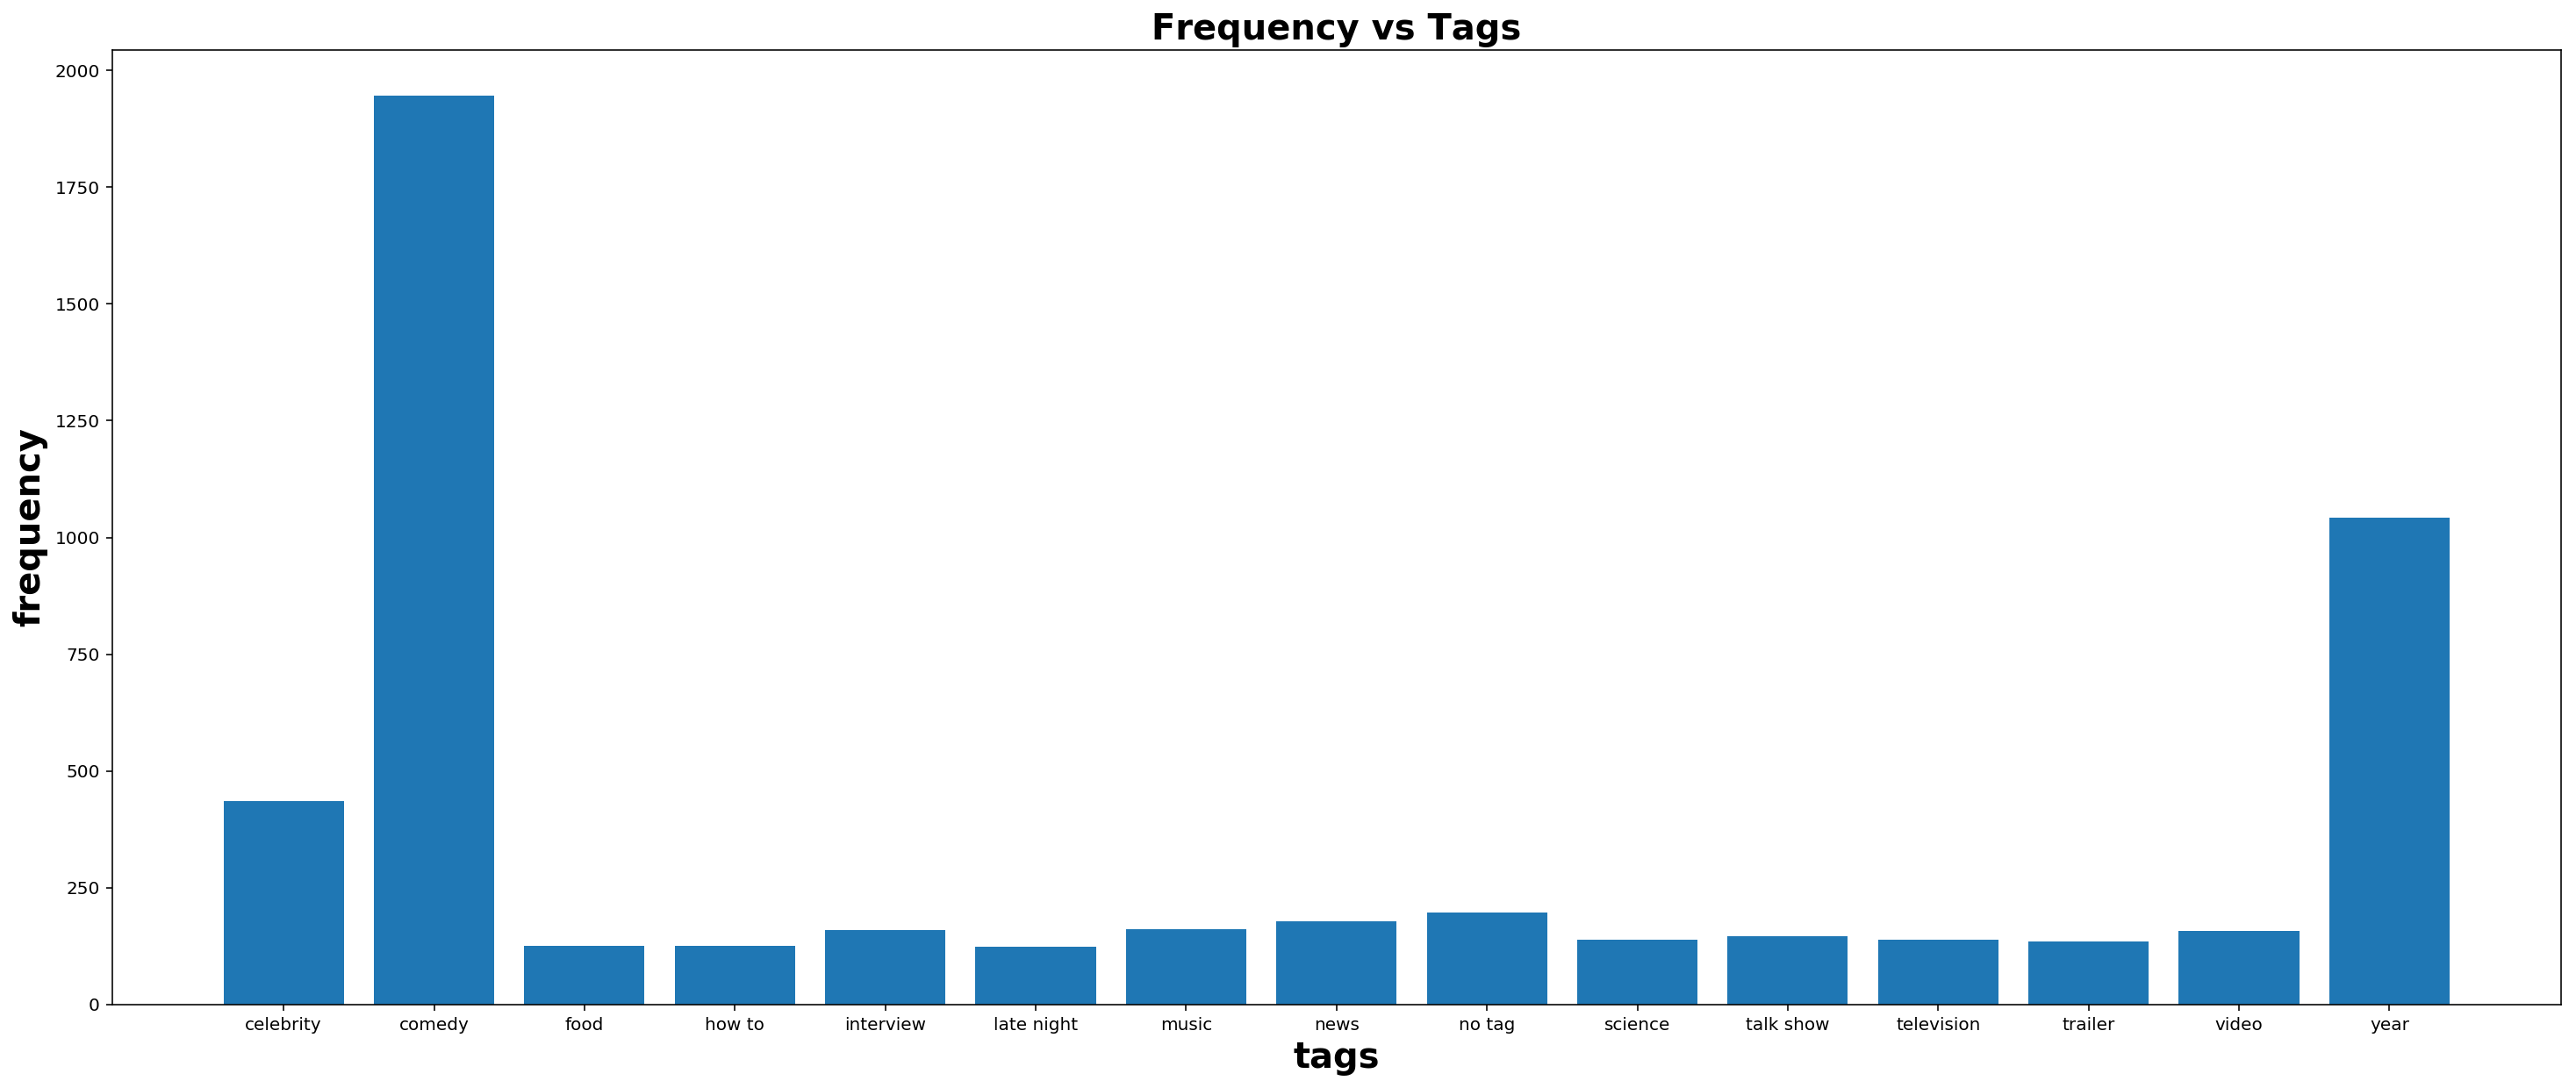

In [70]:
# visualization for frequency of each tag
plt.figure(figsize=(25,10))

plt.bar(tags_key, tags_value)

plt.xlabel('tags', fontsize=20, weight='bold')
plt.ylabel('frequency', fontsize=20, weight='bold')
plt.title('Frequency vs Tags', fontsize=20, weight='bold')
plt.rc('font', size=15)

plt.show()

Similarly, we created sorted lists of the top 20 words appearing in titles and its frequency. When we first ran this, the most common words were articles and prepositions. However, this data was not particulary helpful, so we created a list of unwanted words and omitted them from the visiualization.

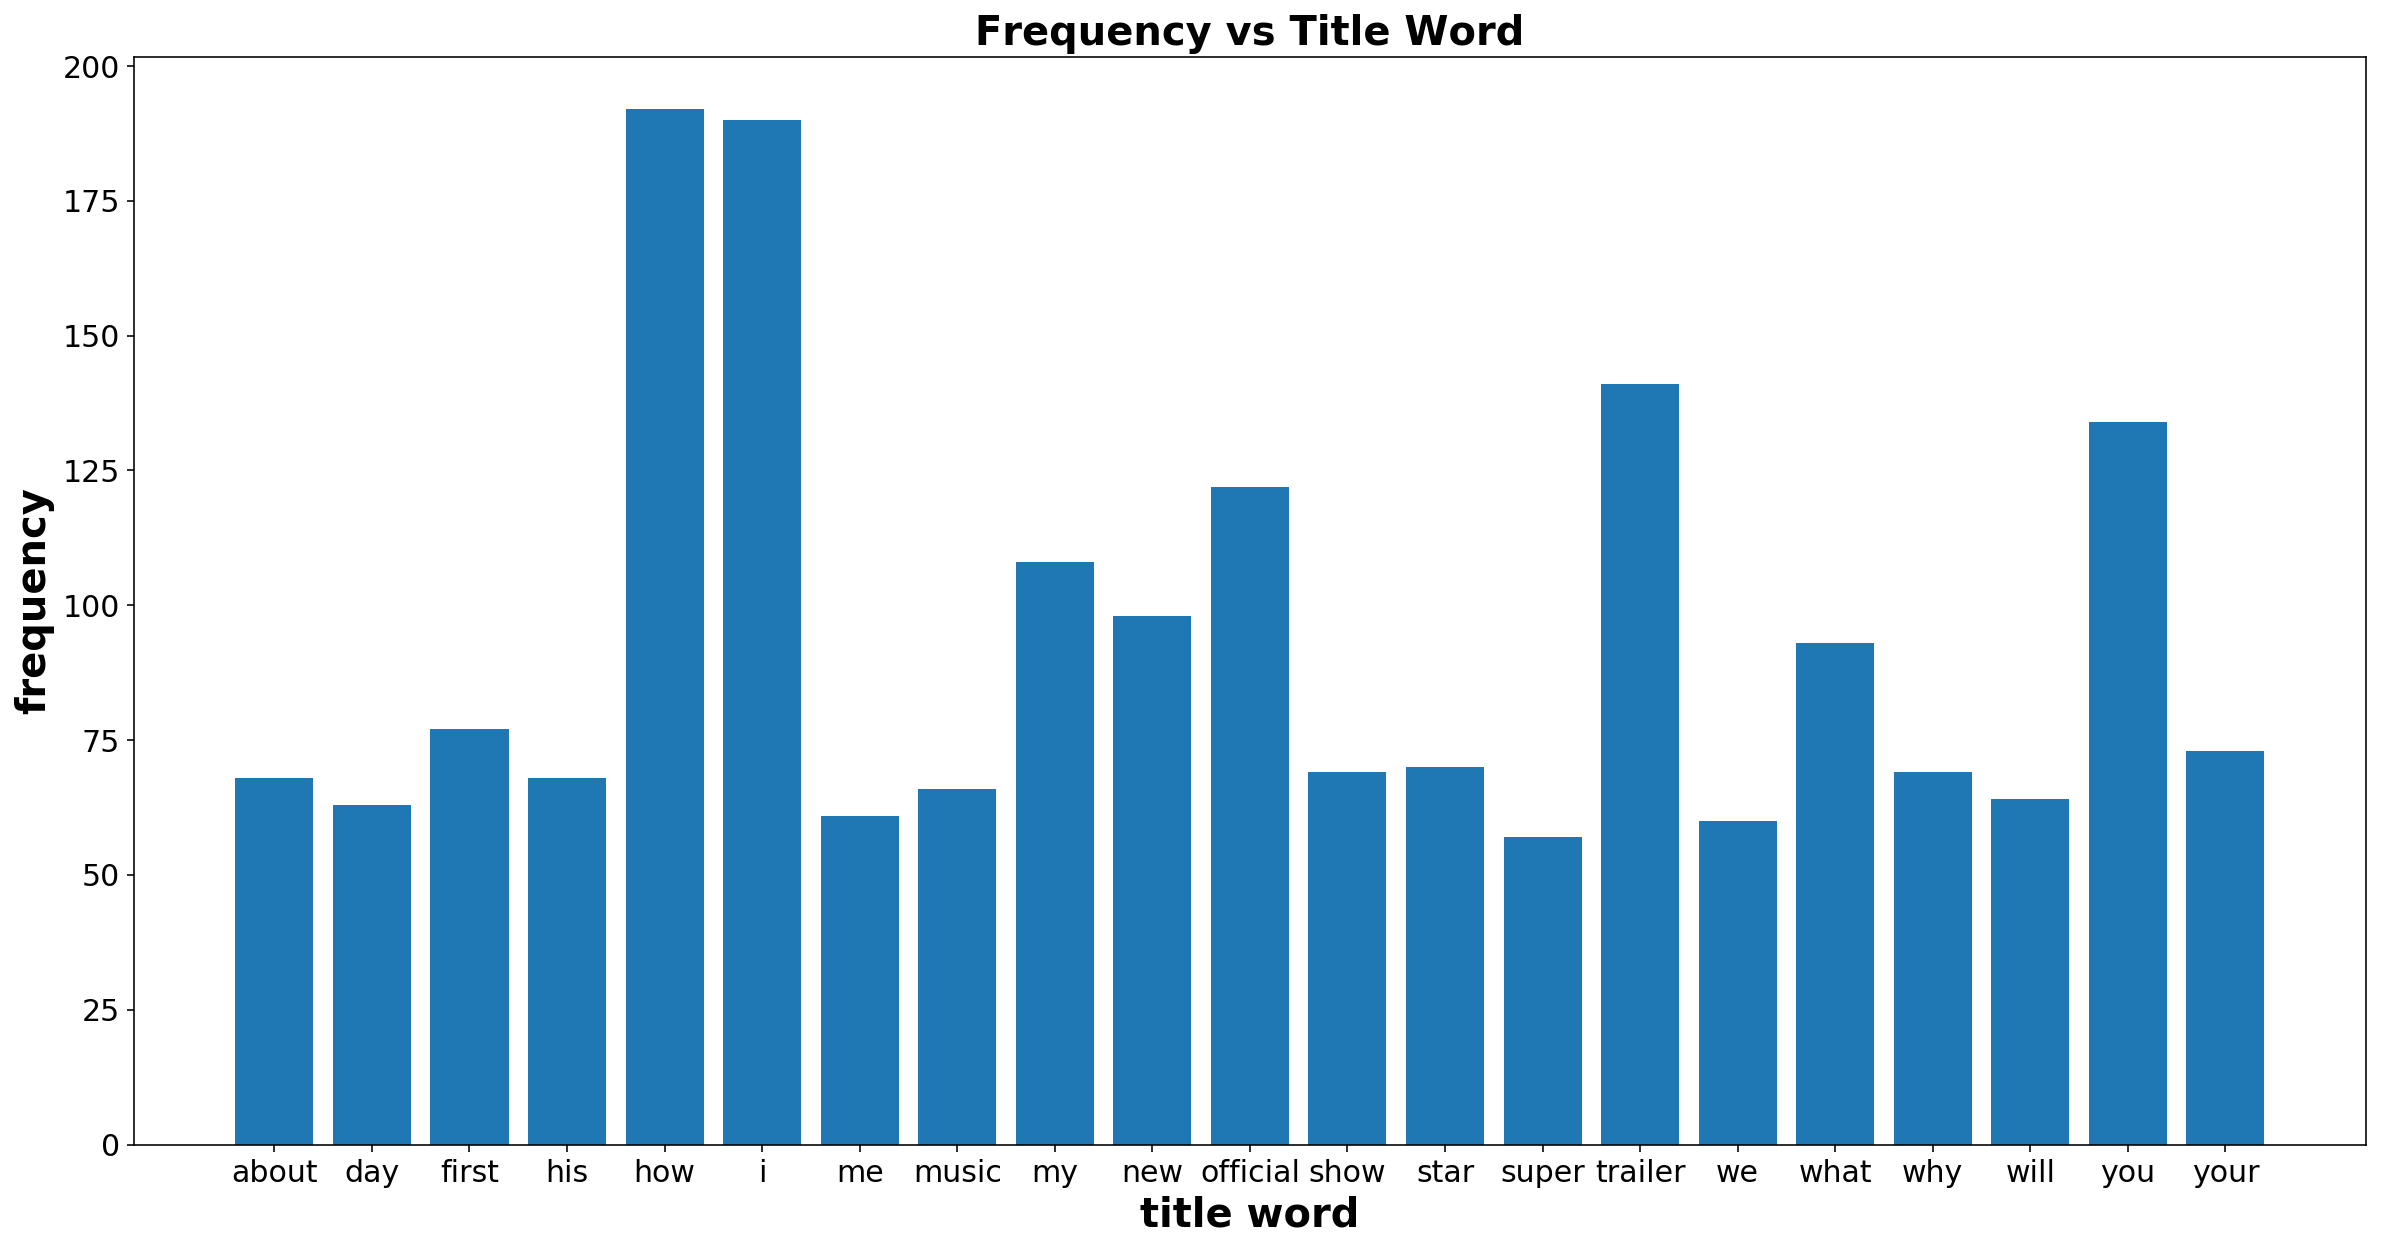

In [71]:
# title and number of times appeared
unwanted_words = ['the', 'a', 'to', 'in', 'of', 'with', 'and', 'on', 'for', 'is', 'at', 
                  'this', 'by', 'it','THE','from']
title_dict_sorted = sorted(title_dict.items(), key=operator.itemgetter(1),reverse = True)[:36]
title_key = []
title_value = []
for item in title_dict_sorted:
    if item[0] not in unwanted_words:
        title_key.append(item[0])
        title_value.append(item[1])

plt.figure(figsize=(20,10))
plt.bar(title_key, title_value)
plt.xlabel('title word', fontsize=20, weight='bold')
plt.ylabel('frequency', fontsize=20, weight='bold')
plt.title('Frequency vs Title Word', fontsize=20, weight='bold')
plt.rc('font', size=15)
plt.show()


Here, we created multiple dictionaries to store our data. We created a month_dict to store the sum of all views by month and a day_dict to store the sum of all views by day. We also created dictionaries for each month to keep track of the number of views on each day of that particular month. For each of these, the key is the month or day and the value is the number of views. 

In [72]:
# date & view count: scatter plot 

# graph per month, x axis is days and then y axis plots how many views
month_dict = {}
day_dict = {} 
nov = {}
dec = {}
jan = {}
feb = {}
mar = {}
sorted_nov = {}
sorted_dec = {}
sorted_jan = {}
sorted_feb = {}
sorted_mar = {}

for index, row in df.iterrows():
    month = row['trend_month'] # month
    day = row['trend_day'] # day
    views = row['views']
    
    if month in month_dict:
        month_dict[month] += views       
    else:
        month_dict[month] = views
  
    if day in day_dict:
        day_dict[day] += views
    else:
        day_dict[day] = views
    
    # create dictionaries for each month
    if month == 11:        
        if day in nov:
            nov[day] += views
        else:
            nov[day] = views

    if month == 12:
        if day in dec:
            dec[day] += views
        else:
            dec[day] = views
            
    if month == 1:
        if day in jan:
            jan[day] += views
        else:
            jan[day] = views
            
    if month == 2:
        if day in feb:
            feb[day] += views
        else:
            feb[day] = views 
            
    if month == 3:
        if day in mar:
            mar[day] += views
        else:
            mar[day] = views       
   
    if day in day_dict:
        day_dict[day] += views
    else:
        day_dict[day] = views

# ignore number of views for 1st day
nov[14] = float('nan')

# add 0 in for missing data
for x in range(1, 32):
    if x not in nov:
        nov[x] = float('nan')
    if x not in dec:
        dec[x] = float('nan')
    if x not in jan:
        jan[x] = float('nan')
    if x not in feb:
        feb[x] = float('nan')
    if x not in mar:
        mar[x] = float('nan')

# update dictionaries in sorted key order
for i in range(1, 32):
    sorted_nov[i] = nov[i]
    sorted_dec[i] = dec[i]
    sorted_jan[i] = jan[i]
    sorted_feb[i] = feb[i]
    sorted_mar[i] = mar[i]

nov = sorted_nov
dec = sorted_dec
jan = sorted_jan
feb = sorted_feb
mar = sorted_mar

For each month, we graphed the total number of views for all trending videos on each day of the month. Each month is graphed in a different color labeled in the legend.

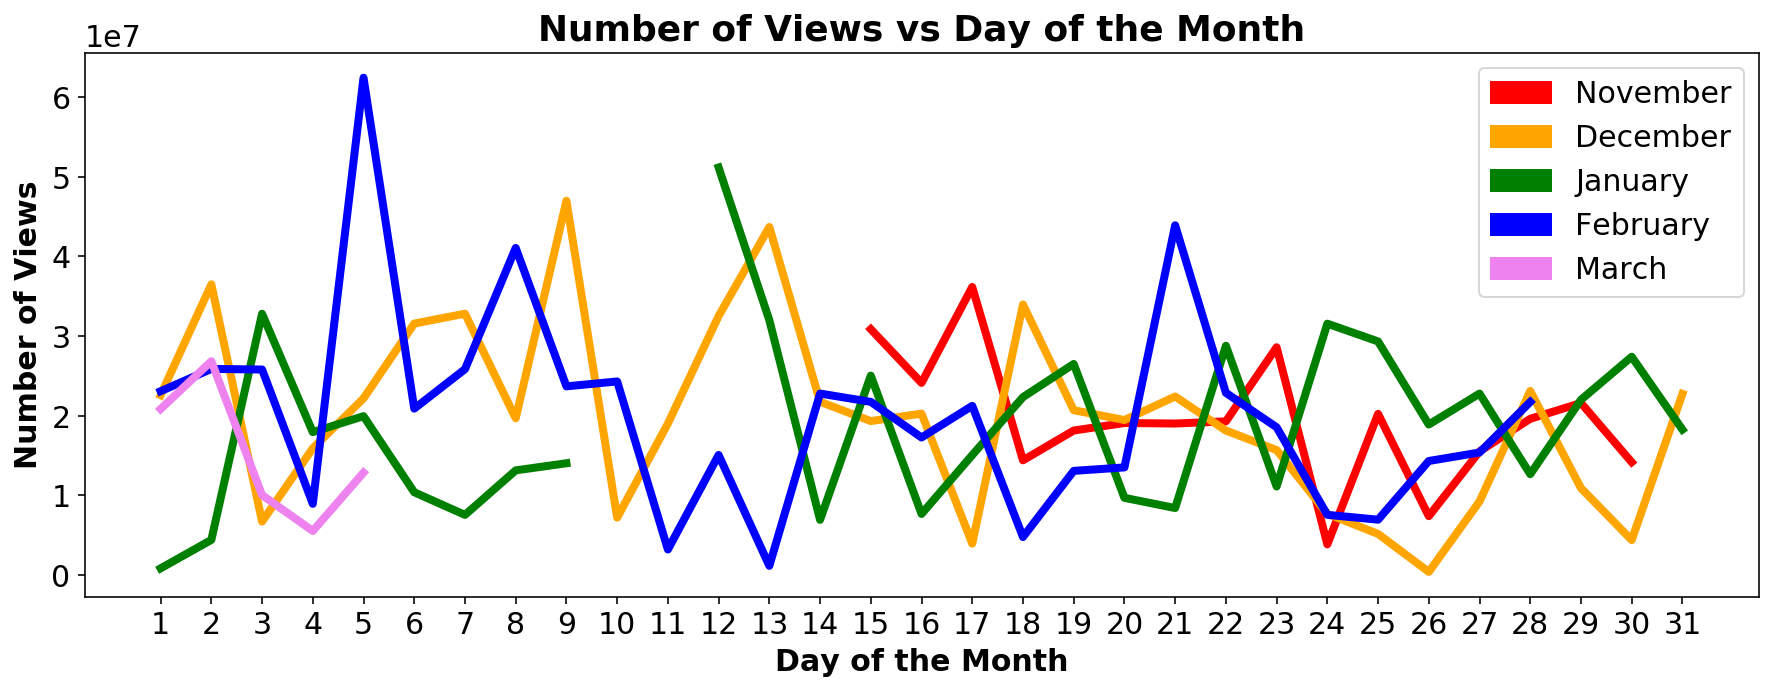

In [73]:
plt.figure(figsize=(15,5))

# plot lines
plt.plot(nov.values(), c ='red', linewidth=4.0)
plt.plot(dec.values(), c='orange', linewidth=4.0)
plt.plot(jan.values(), c='green', linewidth=4.0)
plt.plot(feb.values(), c='blue', linewidth=4.0)
plt.plot(mar.values(), c='violet', linewidth=4.0)

plt.ylabel('Number of Views', weight='bold')
plt.xlabel('Day of the Month', weight='bold')
plt.title('Number of Views vs Day of the Month', weight='bold')

plt.xticks(range(len(list(jan.keys()))), list(jan.keys()))

# make legend
red_patch = mpatches.Patch(color='red', label='November')
orange_patch = mpatches.Patch(color='orange', label='December')
green_patch = mpatches.Patch(color='green', label='January')
blue_patch = mpatches.Patch(color='blue', label='February')
violet_patch = mpatches.Patch(color='violet', label='March')

plt.legend(handles=[red_patch, orange_patch, green_patch, blue_patch, violet_patch])

plt.show()

We then decided to shift our data so that it is aligned by day. We decided to align based on January 1st, which is a Monday. This means that for all other months, we shifted our data to the first Monday of each month. For example, since February 1st is a Thursday, we shifted all of the days in that month by 4 to get to the first Thursday, which is January 5th.

In [74]:
sorted_nov = {}
sorted_dec = {}
sorted_feb = {}
sorted_mar = {}

NOV_CONST = 3
DEC_CONST = 5
FEB_CONST = 4
MAR_CONST = 4

# add 0 values for unshifted days
for i in range(1, 6):
    if i < NOV_CONST:
        sorted_nov[i] = float('nan')
        
    if i < DEC_CONST:
        sorted_dec[i] = float('nan')

    if i < FEB_CONST:
        sorted_feb[i] = float('nan')
        
    if i < MAR_CONST:
        sorted_mar[i] = float('nan')

# shift to the right
for i in range(1, 32):
    sorted_nov[i+NOV_CONST-1] = nov[i]
    sorted_dec[i+DEC_CONST-1] = dec[i]
    sorted_feb[i+FEB_CONST-1] = feb[i]
    sorted_mar[i+MAR_CONST-1] = mar[i]

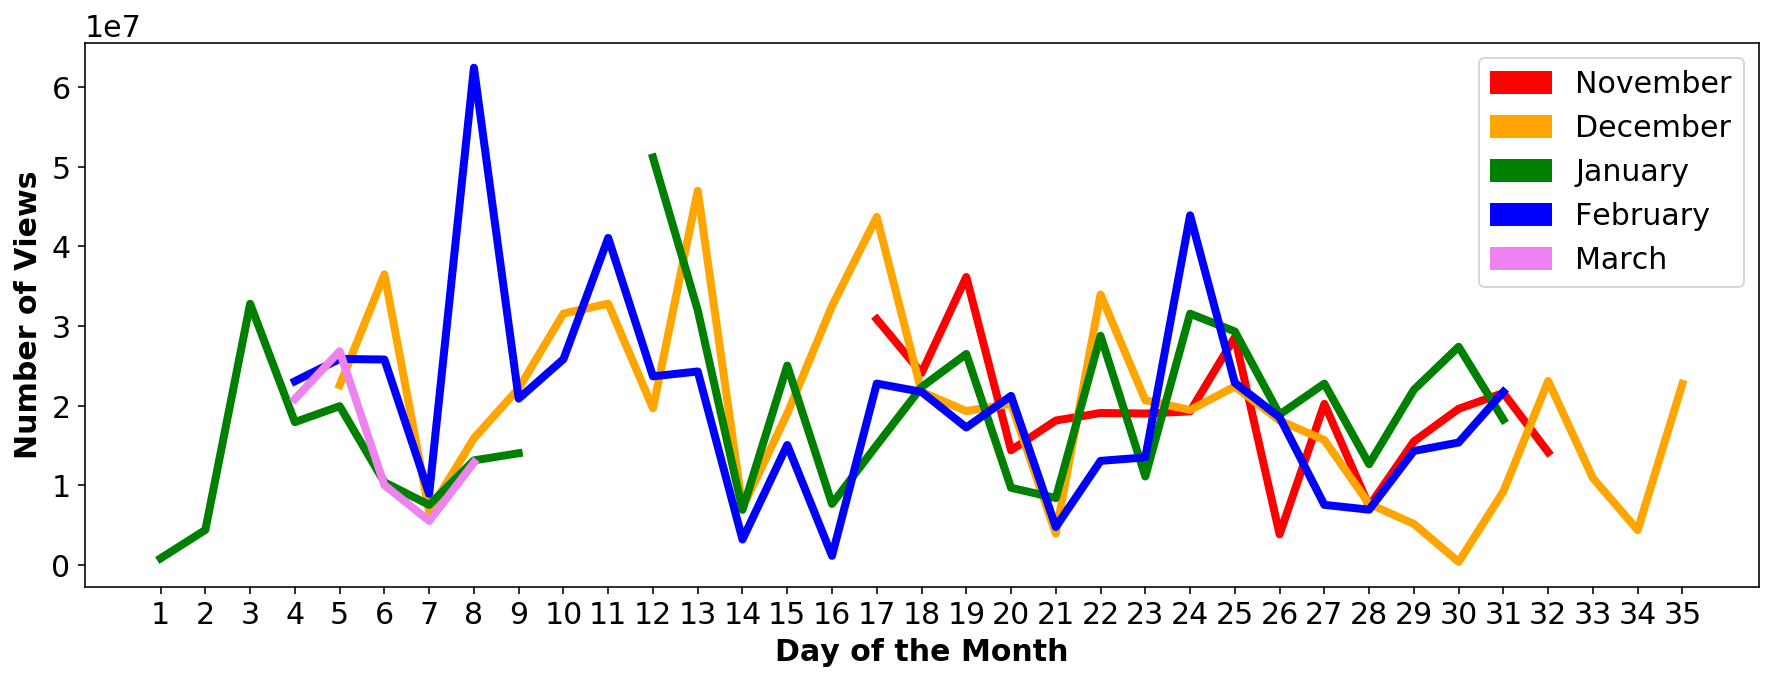

In [75]:
plt.figure(figsize=(15,5))

# plot lines
plt.plot(sorted_nov.values(), c ='red', linewidth=4.0)
plt.plot(sorted_dec.values(), c='orange', linewidth=4.0)
plt.plot(jan.values(), c='green', linewidth=4.0)
plt.plot(sorted_feb.values(), c='blue', linewidth=4.0)
plt.plot(sorted_mar.values(), c='violet', linewidth=4.0)

plt.ylabel('Number of Views', weight='bold')
plt.xlabel('Day of the Month', weight='bold')
plt.xticks(range(len(list(sorted_dec.keys()))), list(sorted_dec.keys()))

# make legend
red_patch = mpatches.Patch(color='red', label='November')
orange_patch = mpatches.Patch(color='orange', label='December')
green_patch = mpatches.Patch(color='green', label='January')
blue_patch = mpatches.Patch(color='blue', label='February')
violet_patch = mpatches.Patch(color='violet', label='March')

plt.legend(handles=[red_patch, orange_patch, green_patch, blue_patch, violet_patch])

plt.show()

In this section, we calculate the number of times that there was a trending video in each category. Some categories had no videos, so we removed them from the pie chart. We also grouped the categories that made up less than 2% of the pie chart into a 'other' category to make the chart more readable.

In [76]:
#category id percentages
colors = ['olive', 'red', 'cyan','gold', 'green', 'lime', 'aquamarine','teal','lavender',
         'fuchsia','orange','violet']

explode = (0, 0, 0, 0, 0, 0, 0.05, 0, 0, 0, 0, 0)
cat_id = dict.fromkeys([1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 0) 
for index, row in df.iterrows():
    id_val = row['original_id']
    cat_id[id_val] += 1
    

cat_id_update = {k:v for k, v in cat_id.items() if v >= 110}
cat_id_update[45] = cat_id[19] + cat_id[20] + cat_id[29] + cat_id[43]

categories_update = {1:'Film & Animation', 10:'Music', 15:'Pets & Animals', 17:'Sports', 
                22:'People & Blogs', 23:'Comedy', 24:'Entertainment', 
                25:'News & Politics', 26:'Howto & Style', 27:'Education', 28:'Science & Technology', 45: 'Other'}



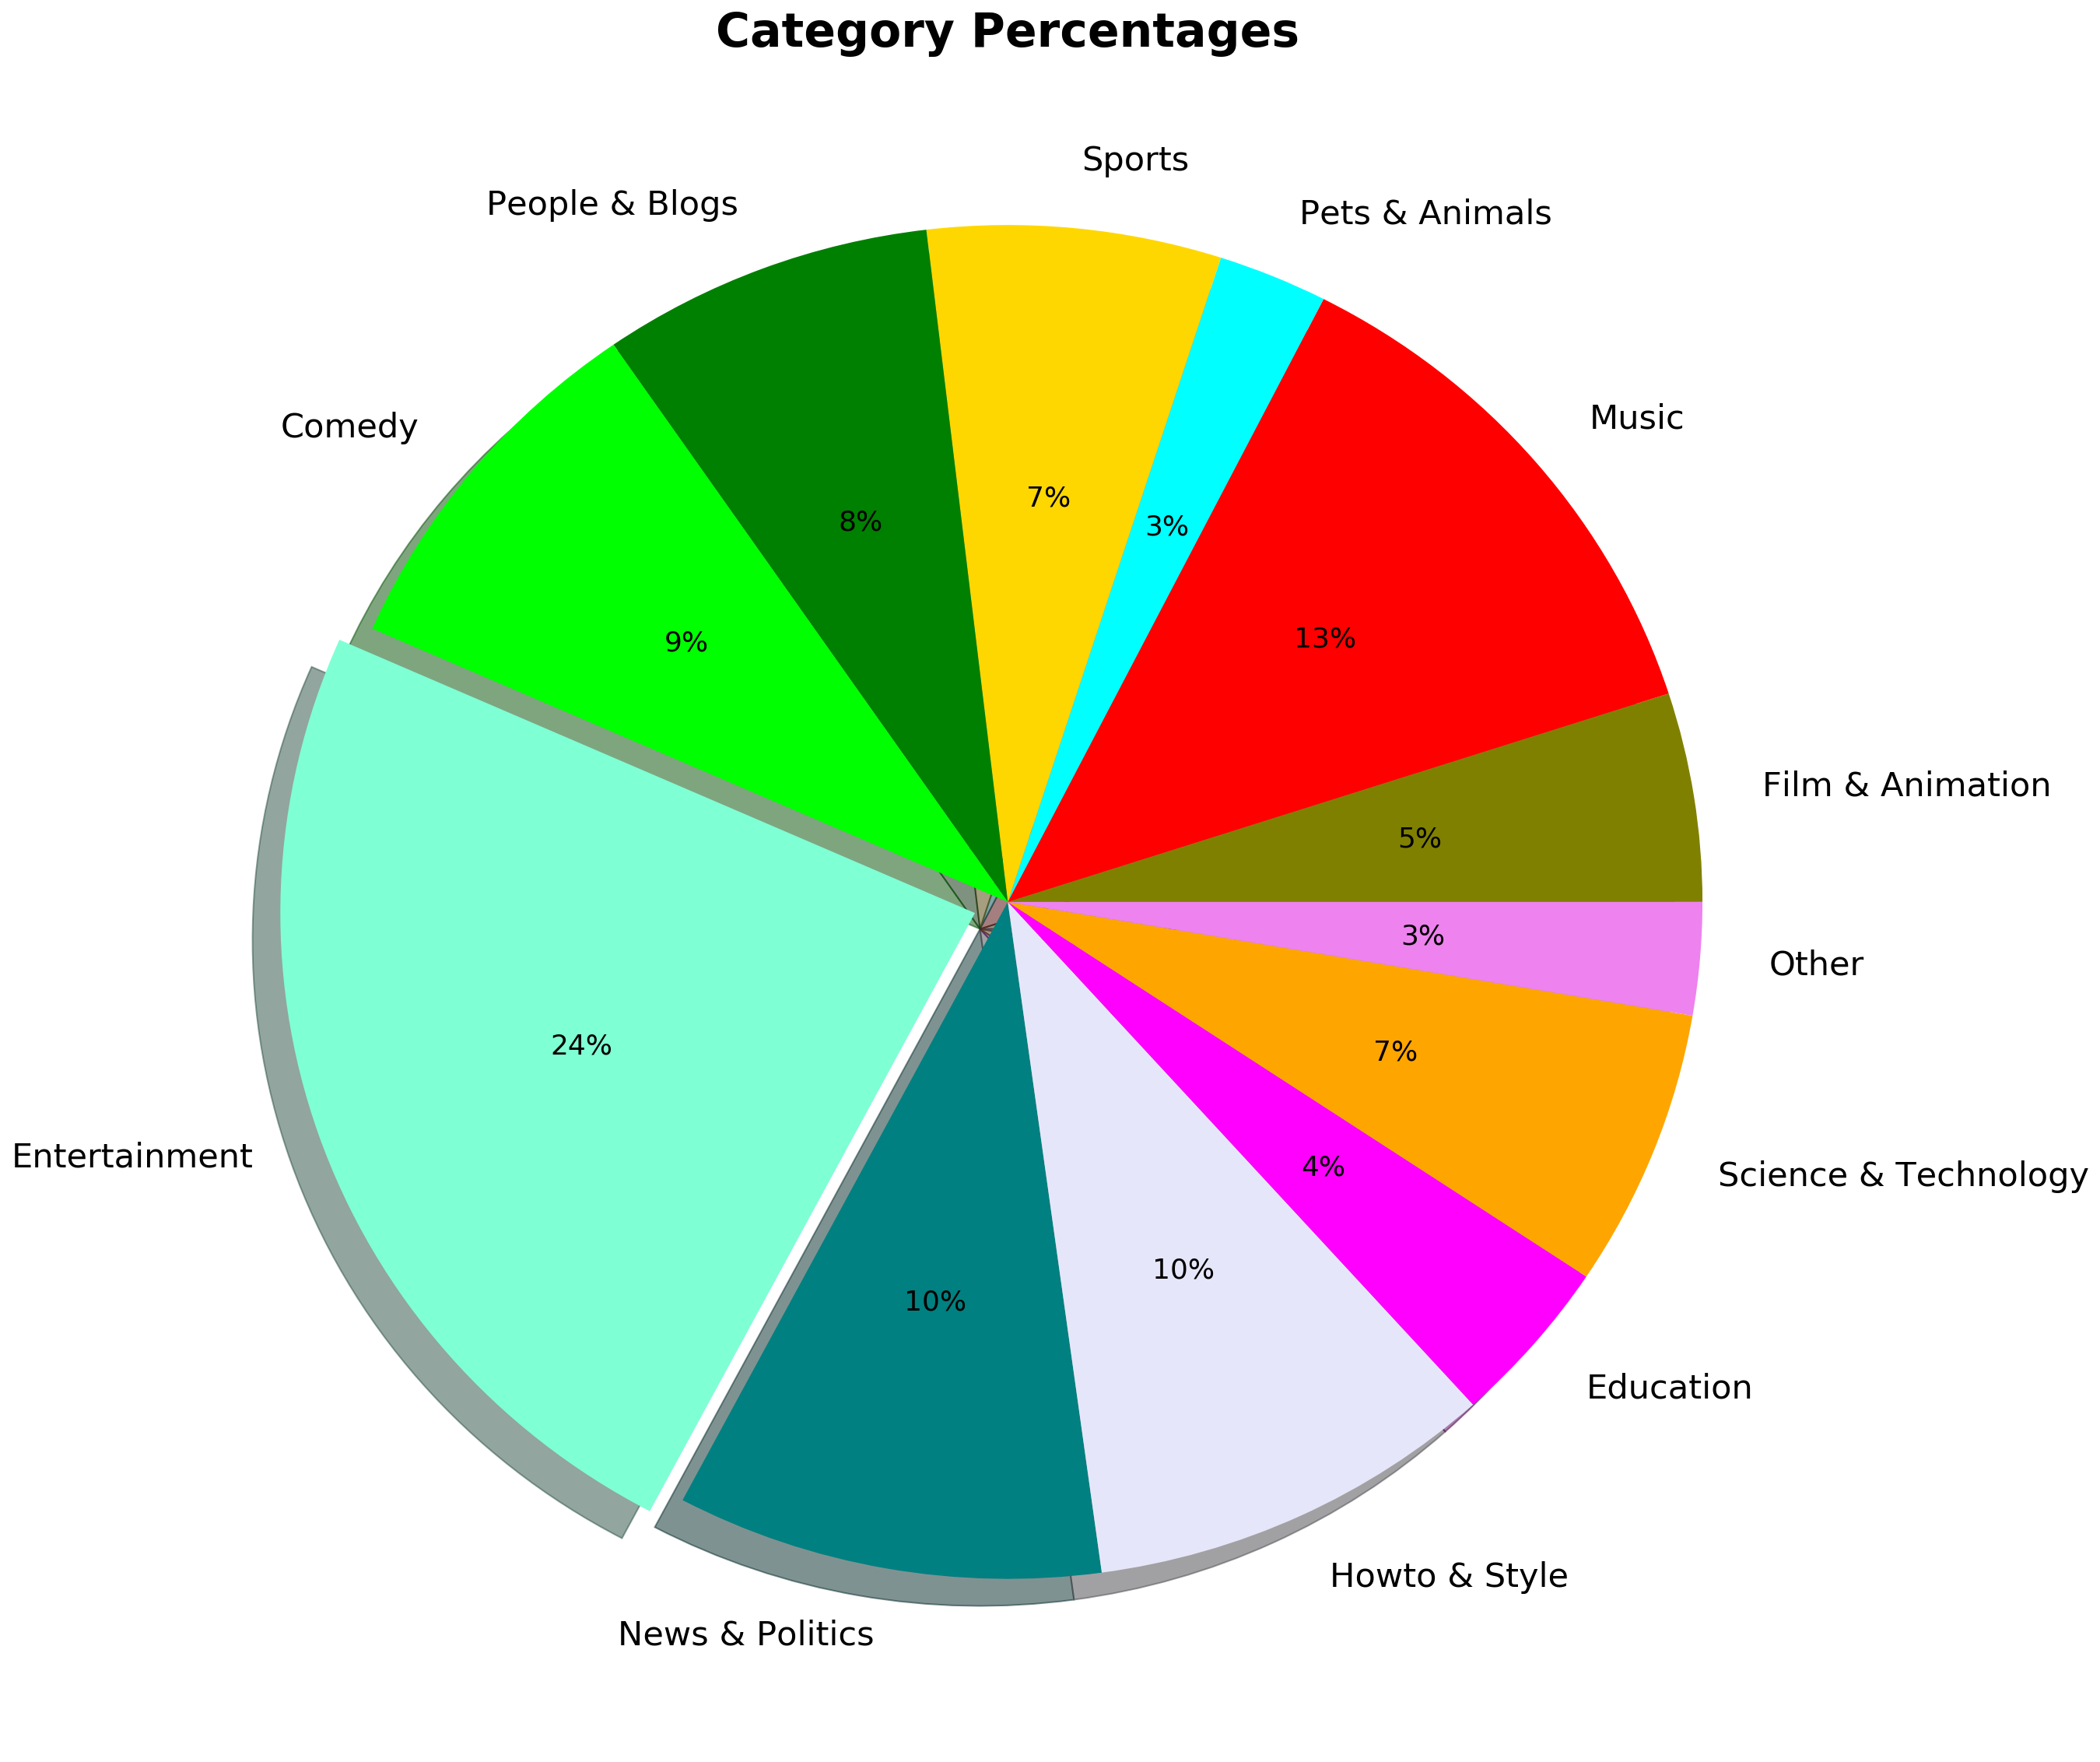

In [77]:
#pie for category id percentages
plt.figure(figsize=(20,20))
patches, texts, autotexts =plt.pie(cat_id_update.values(), labels=categories_update.values(),autopct='%.0f%%',
                                   shadow=True, explode=explode,colors=colors)
for t in texts:
    t.set_size('x-large')
for t in autotexts:
    t.set_size('larger')
plt.title('Category Percentages', fontsize=30, weight='bold')
plt.show()

We plotted the all of the data of subscriber count and views. We set a max and min subs threshold so we only look at videos from channels that have a subscriber count between 100,000 and 1,000,000. This threshold was chosen because of the way subscriber counts were initially scraped. For channels with over 1 million subscribers or under 100,000 subscribers, the video link only shows 2 significant figures for the subscriber count. Initially the code we wrote to scrape for the exact subscriber count took too long to run so we were unable to include it in our data frame. We wanted to minimize clustering of data so we chose to only look at data points with 3 significant figures.

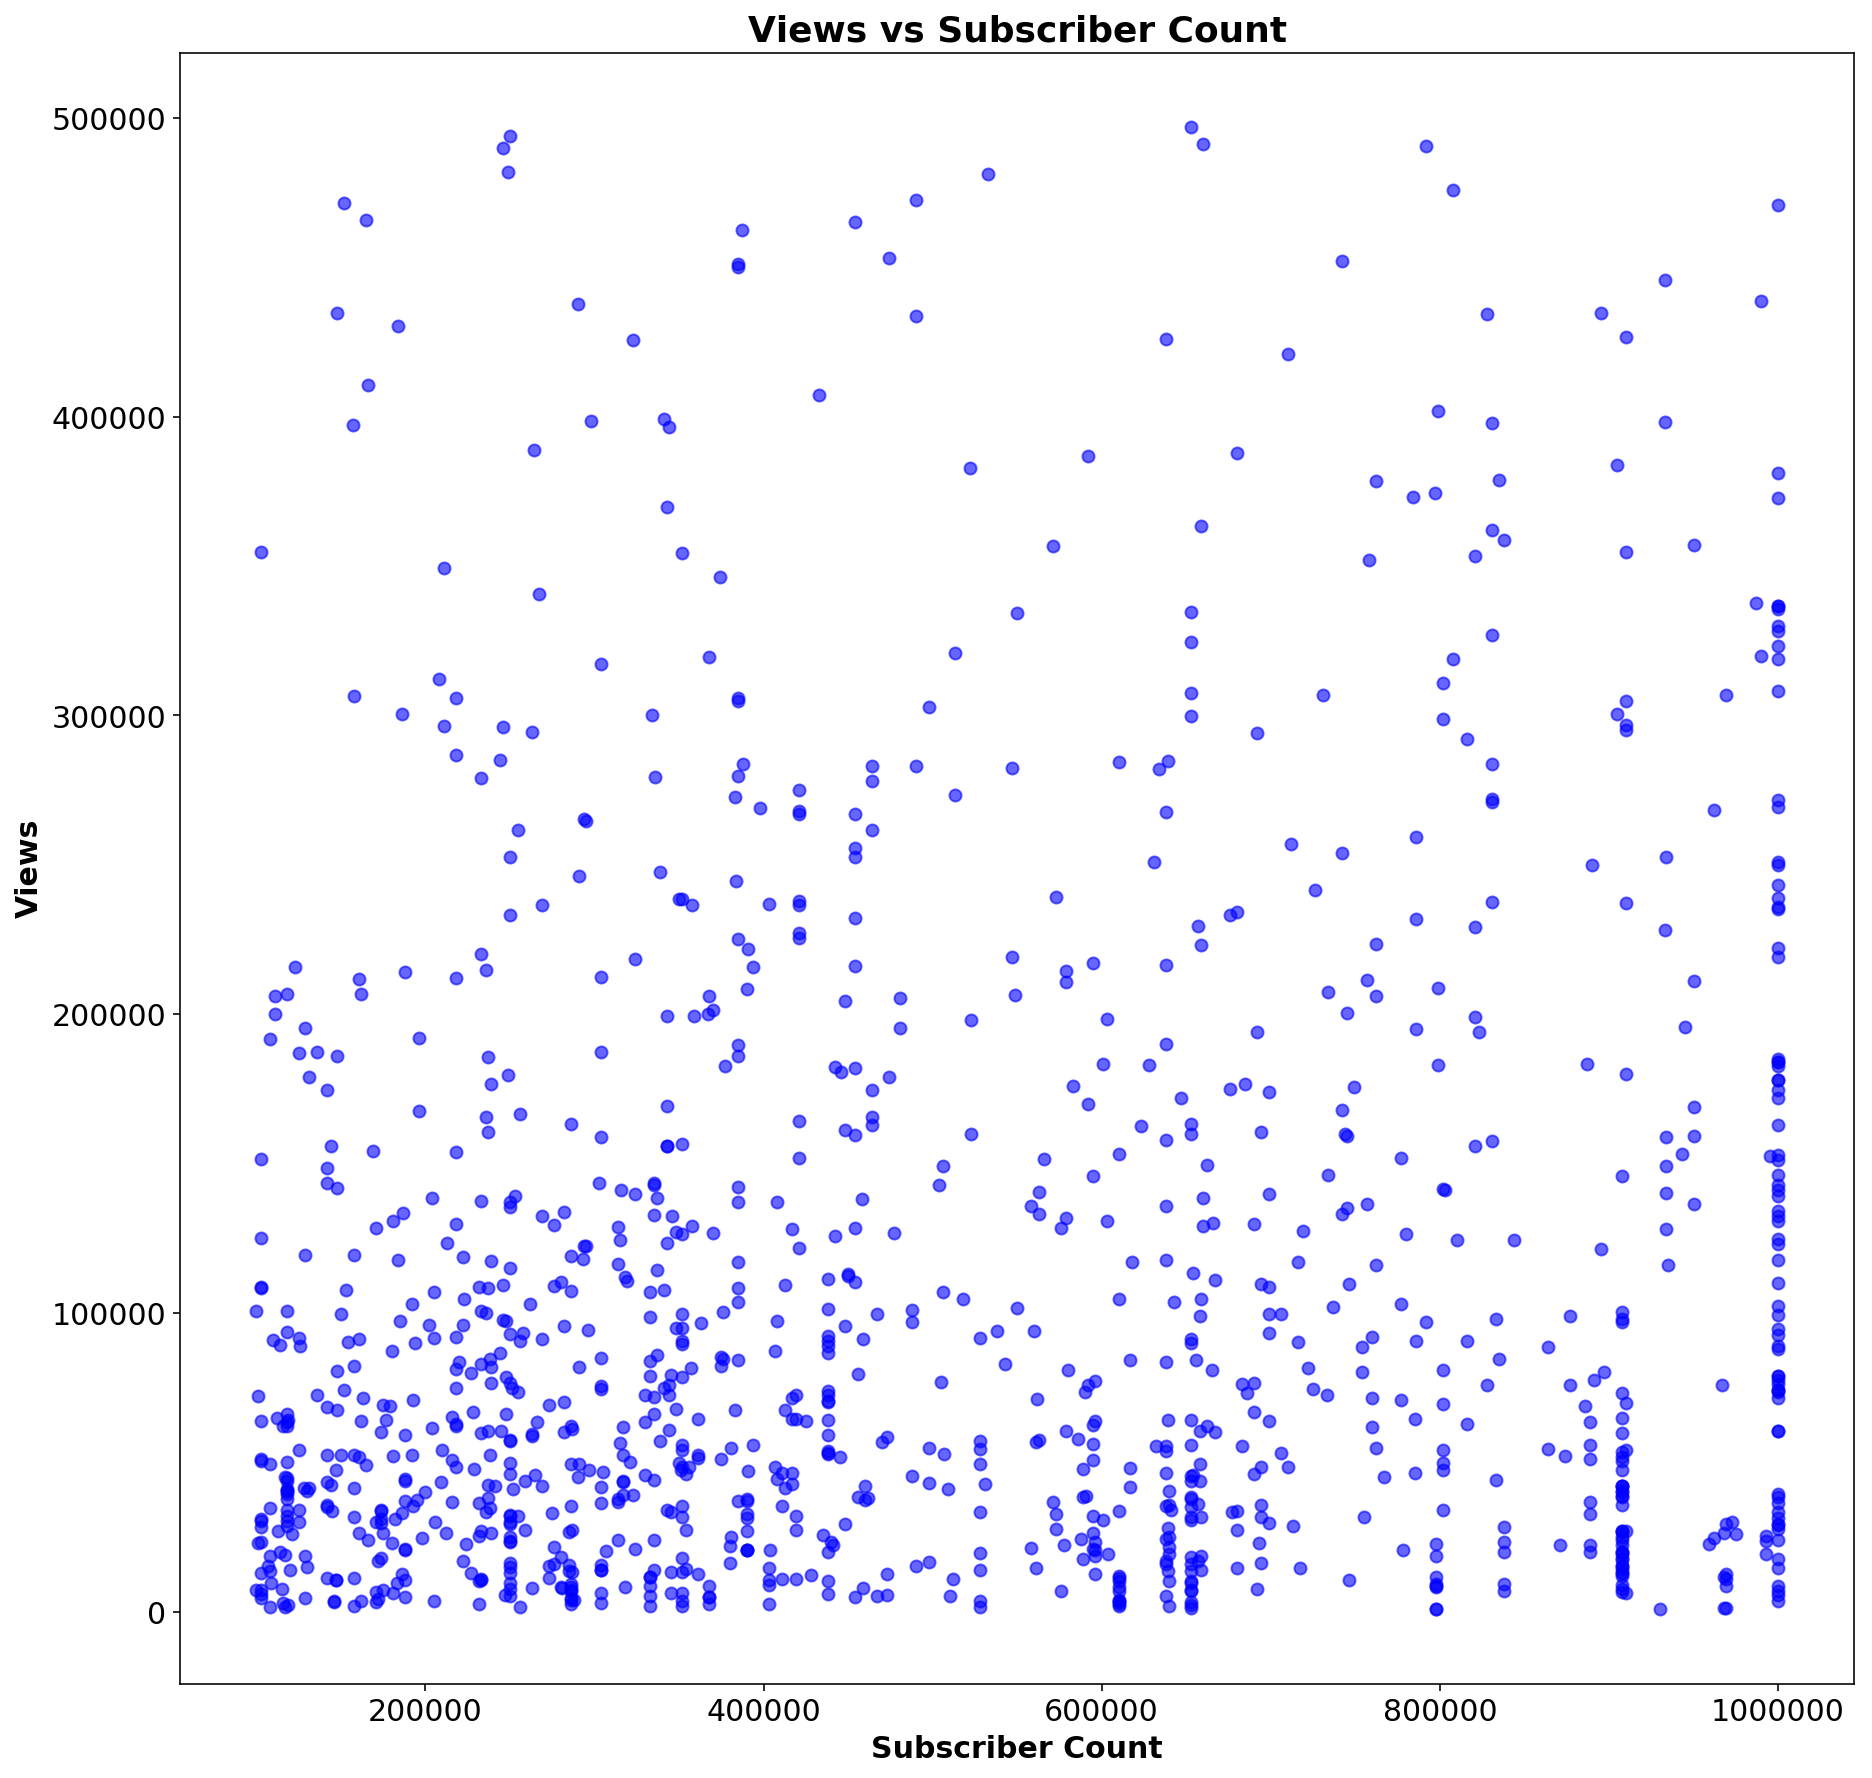

In [78]:
fig = plt.figure(figsize=(15,15))
ax = plt.axes()

# various thresholds
MAX_SUBS = 1000000
MIN_SUBS = 100000
MAX_VIEWS = 500000

subs = df.copy()

subs['sub_count'] = subs['sub_count'].astype(float)
df['sub_count'] = df['sub_count'].astype(float)

# drop unwanted values
subs = subs[subs['sub_count'] <= MAX_SUBS]
subs = subs[subs['sub_count'] >= MIN_SUBS]
subs = subs[subs['views'] <= MAX_VIEWS]

ax.scatter(subs["sub_count"].tolist(), subs["views"].tolist(), c='blue', alpha=0.6)

plt.title("Views vs Subscriber Count", weight='bold')
plt.xlabel("Subscriber Count", weight='bold')
plt.ylabel("Views", weight='bold')
plt.show()

## Data Analysis and Results

The first factor we analyzed was how many times a category of tags appeared in the trending videos. Our findings revealed that the most commonly used tags amongst the trending videos were in the comedy category, which includes the tags, “comedy,” “comedians,” “funny,” “humor,” and “jokes.” The second most commonly used tags were ones indicating the year, which for our data consisted of “2017” or “2018.” “Celebrity” or “celebrities” were the tags that followed, and the next largest group of videos actually contained no tags. This affirms our original hypothesis that trending videos would mostly be in the comedy category as we find that most people use YouTube as a platform for comedic entertainment. Based on the tags of trending videos, it seems that the primary reason many people use Youtube is to humor themselves.

Our next point of analysis was viewing the words contained in the title of the videos. We found that the top 5 words to appear in the title were “how,” “I,” “trailer,” “you,” and “official.” We originally predicted that there would be lots of controversial words in the title but this data disproved that idea. Instead of controversial words, we found that everyday common words were more frequent, as “how” and “I” appeared the most number of times. For example, “how” is a word that can apply to a huge variety of people, whether it be “how” to do/fix something, “how” to learn a dance, “how” someone’s day was (for vlogs), and so on. Words like “trailer” and “official” would be common because YouTube is the most prominent platform that people can watch official trailers on, other than actual movie theaters themselves. The tendency for trending videos goes towards leisure-type videos. Most viewers seem to watch videos related to everyday life rather than huge news or controversial topic videos as we predicted. 

The below OLS regression results is comparing the views and the sub_count in our dataframe that is visualized in the chart. We found that the coefficient for the sub_count is 0.0601 which means the correlation is very slightly positive between sub_count and the views of the trending videos.

In [79]:
outcome, predictors = patsy.dmatrices('views ~ sub_count', subs)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     28.14
Date:                Thu, 22 Mar 2018   Prob (F-statistic):           1.34e-07
Time:                        21:44:23   Log-Likelihood:                -15347.
No. Observations:                1180   AIC:                         3.070e+04
Df Residuals:                    1178   BIC:                         3.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.033e+04   6465.594     12.424      0.0

In the cell below we were curious about how the overall views and sub_count would relate to the certain subset of the data we took and made the OLS regression results between the views and sub_count for all of our data. The coefficient seemed to be a little more positive than our subset suggested.

In [80]:
outcome2, predictors2 = patsy.dmatrices('views ~ sub_count', df)
mod2 = sm.OLS(outcome2, predictors2)
res2 = mod2.fit()

print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                  views   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     566.4
Date:                Thu, 22 Mar 2018   Prob (F-statistic):          7.72e-118
Time:                        21:44:23   Log-Likelihood:                -67700.
No. Observations:                4380   AIC:                         1.354e+05
Df Residuals:                    4378   BIC:                         1.354e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.24e+05   2.27e+04      9.851      0.0

In our graph comparing the day of the month with the views each month seemed random, and the part of the month and the number of views was not very correlated. Therefore, it seems that the part of the month, such as the beginning of the end of the month does not affect if a video trends or not. However, when we shifted the days to match up by the day of the week there seemed to a correlation between the two. We hypothesized that videos posted on Friday were to trend more because it was the end of the work week and most people have free time on Friday to watch Youtube. From our visualization it seems the trending videos with the least amount of views were posted on Sunday and the videos with the most amount of views were posted either on Monday or Friday. It was very interesting to see how the graph consistently shows how each Sunday (days 7, 14, 21, 28) the number of views dips down significantly. This makes sense because most people on Sunday are probably going to be busy whether it is because of a religious reason, prepping for the next week, or other reasons.

Our pie chart represents the percentage of videos that appear in certain category IDs. The highest percentage is the entertainment category which reiterates the idea that YouTube is a primary source for leisure and entertainment videos. Some videos included in the entertainment category are “Batman Trailer” or “Justin Bieber Carpool Karaoke.” The second largest percentage was Music which range videos from live performances to music video behind the scenes. Trending music videos emphasize the timeliness of trendy videos, as musical popularity is extremely time-based and most prominent when new. On the other hand, the smallest percentages were grouped into the “Other” categories and contained Travel and Events, Gaming, Nonprofits and Activism, and Shows. These categories seem to offer the least “entertainment” values other than Gaming. Although YouTube’s most subscribed channel, Pewdiepie, is a gaming channel, it’s not common that gaming videos trend, most likely due to their long durations and lack of appeal to all genders and ages.

We predicted that, typically, trending videos usually come from large channels with close to millions of subscribers. However, as shown in our data, this is not necessarily true. Our scatter plot diagram displays the number of subscribers for each video in correlation to their view counts. The majority of the points are plotted to the to the bottom left of the graph which indicates that most trending videos actually don’t come from huge channels since most of the channels don’t have 10 million subscribers

## Privacy/Ethics Considerations

Acquiring data from Kaggle for trending YouTube videos does not raise much concern with privacy as both Kaggle and YouTube are public domains that are open and free for the public. In addition, we are scraping from data that is already available to the public. While there are no privacy issues, there are, however, some biases that need to be considered. By only examining data from trending videos, we are only considering the factors that many videos have in common. Trending videos might have similarities that are not unique to just trending videos. For example if a video has the tag “funny” then this does not necessarily mean that the video will go trending because many YouTube videos share the tag “funny”. Other videos may share this similarity but may not ever trend; there are countless YouTube videos that contain all the features required for a trending video that do not trend at all. If we were to have a next step we would try to compare the trending videos with non-trending videos to see the similarities and difficulties to look from a non-biased perspective. Another bias that we had in our project was only looking at channels that had between 100,000 to 1,000,000 subscribers for our visualization. This was because in our scraping it took to long to get more significant figures due to the fact that we had to scrape an additional website for every data point we had. Therefore we decided our best option was to look at channels that had 3 significant figures of subscribers.


## Conclusions and Discussion

Our group's hypothesis was that the biggest factors that make YouTube videos trend are the use of controversial words in the title and tags, publish times on Fridays, video categories in music and comedy, and a high number of subscribers. However, what we found was that biggest factors that make videos trend was that there were common words in the title such as the word "how". We decided this was because people watch Youtube to learn new things and to educate themselves about things. The day to publish videos was Friday or Monday due our graph which peaks on those days. The day not to post videos because they would get less views would be on Sunday. The video categories that most trending videos were classified in were entertainment and comedy which is reasonable because it supports our reasoning that people watch Youtube for entertainment and to humor themselves. Interestingly, we did not find a very strong correlation between the subscriber counts of the channel that posted the video and the views on the video. It seemed that trending videos with various views could come from any channel no matter the amount of subscribers that channel has.

There are many applications that this project could have. In the future we would like to see how our results would differ if we did the same analysis on different countries that were provided from our dataset. It would be interesting to see if different countries use Youtube for different purposes. In addition to this we would also like to consider comparing trending videos with non-trending videos in order to see the difference between them to look from a non-biased perspective. One way that we could look at it was look at a channel that had many videos that were trending and look at some non-trending ones and analyze why they were not trending like the channel's other videos.